In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from qpfs import QPFS, MultivariateQPFS

In [2]:
def score_vs_alpha3(qpfs, alpha3_array):
        
    alphas_history = []
    score_history = []
    for alpha3 in tqdm_notebook(alpha3_array):
        alphas = qpfs.get_alpha(alpha3)
        qpfs.solve_problem(alphas)
        alphas_history.append(alphas)
        score_history.append((qpfs.zx, qpfs.zy))
    return score_history, alphas_history

In [3]:
# проверим как работают алгоритмы
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
Y = np.repeat(y[:, np.newaxis], repeats=10, axis=1)
X = np.hstack([X, np.zeros((X.shape[0], 1))])

In [4]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()

qpfs.fit(X, y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.score]))

qpfs = QPFS()
qpfs.fit(X, Y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.score]))


mqpfs.get_params(X, y)
alpha = np.mean(mqpfs.Qx) / (np.mean(mqpfs.Qx) + np.mean(mqpfs.B))
mqpfs.solve_problem([1 - alpha, alpha, 0.])
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))

mqpfs.get_params(X, Y)
alpha = np.mean(mqpfs.Qx) / (np.mean(mqpfs.Qx) + np.mean(mqpfs.B))
mqpfs.solve_problem([1 - alpha, alpha, 0.])
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))

0.0722	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000
0.0721	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000
0.0757	0.0677	0.0469	0.1153	0.0453	0.1787	0.0446	0.0000	0.0329	0.0494	0.1188	0.0908	0.1340	0.0000
0.0761	0.0704	0.0567	0.1058	0.0532	0.1466	0.0542	0.0251	0.0485	0.0576	0.1066	0.0858	0.1135	0.0000


In [5]:
# пример, где qpfs плох, а mqpfs гуд

Q = np.array([[1., 0., .0],
               [0., 1., 0.8],
               [.0, 0.8, 1.]])
Qx = Q.copy()
print(Q)
r = 5
Qy = np.ones((r, r)) * 0.2
Qy[:r - 1, :r - 1] = np.ones((r - 1, r - 1))
np.fill_diagonal(Qy, 1.)
print(Qy)
B = np.hstack((np.repeat(np.array([[0.4], [0.5], [0.8]]), repeats=r - 1, axis=1), 
               np.array([[0.], [.8], [.1]])))
print(B[:, :17])
b = np.mean(B, axis=1, keepdims=True)
print(b)

[[ 1.   0.   0. ]
 [ 0.   1.   0.8]
 [ 0.   0.8  1. ]]
[[ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]
[[ 0.4  0.4  0.4  0.4  0. ]
 [ 0.5  0.5  0.5  0.5  0.8]
 [ 0.8  0.8  0.8  0.8  0.1]]
[[ 0.32]
 [ 0.56]
 [ 0.66]]


In [13]:
mqpfs.Qx = Qx
mqpfs.Qy = Qy
mqpfs.B = B
mqpfs.n, mqpfs.r = B.shape

alphas = mqpfs.get_alpha()
print(alphas)
mqpfs.solve_problem(alphas)

print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))

[ 0.37276597  0.37115227  0.25608176]
0.3835	0.5213	0.0952


In [14]:
alpha3_array = np.linspace(0, 1, 300)
score_history, alphas_history = score_vs_alpha3(mqpfs, alpha3_array)

A Jupyter Widget

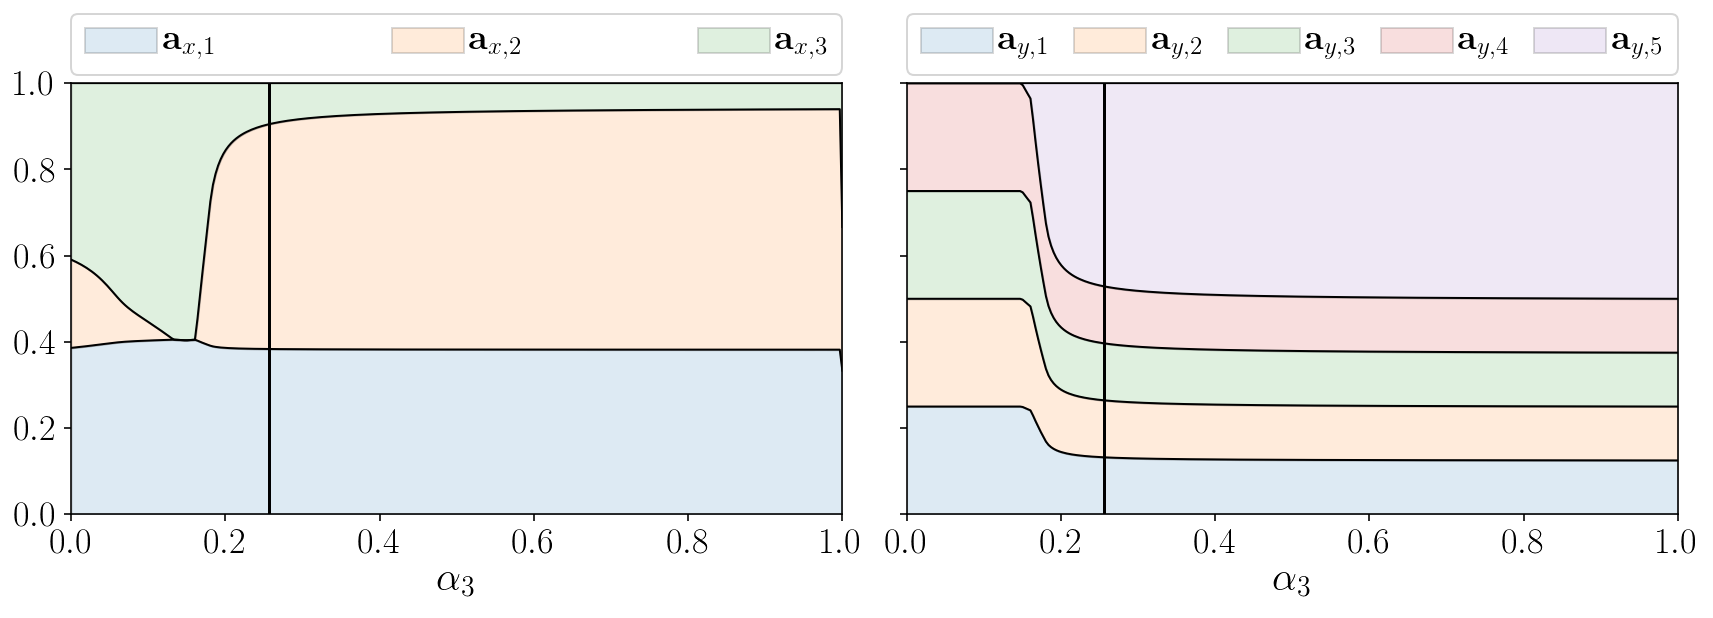

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
n_x, n_y = mqpfs.B.shape
prev = 0.
for i in range(n_x):
    cur = [np.sum(sh[0][:i + 1]) for sh in score_history]
    ax1.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax1.fill_between(alpha3_array, cur, prev, edgecolor='k', alpha=.15, 
                     label=r'{}'.format('$\mathbf{a}_{x,' + str(i + 1) + '}$'))
    prev = cur

ax1.axvline(x=alphas[-1], c='k')
ax1.set_ylim(0., 1.)
ax1.set_xlim(0., 1.)

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_x, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax1.set_xlabel(r'$\alpha_3$')

prev = 0.
for i in range(n_y):
    cur = [np.sum(sh[1][:i + 1]) for sh in score_history]
    ax2.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax2.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                     label=r'{}'.format('$\mathbf{a}_{y,' + str(i + 1) + '}$'))
    prev = cur

ax2.axvline(x=alphas[-1], c='k')
ax2.set_ylim(0., 1.)
ax2.set_xlim(0., 1.)

lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_y, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax2.set_xlabel(r'$\alpha_3$')

fig.tight_layout()
fig.subplots_adjust()
fig.savefig('figs/features_vs_alpha.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()